In [14]:
import json
from collections import Counter

# Load JSON file
with open("results_expanded_formatted.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Count occurrences of key attributes
bias_counts = Counter(d["bias-rating"] for d in data)
credibility_counts = Counter(d["mbfc-credibility-rating"] for d in data)
media_type_counts = Counter(d["media-type"] for d in data)
country_counts = Counter(d["country"] for d in data)

# Print insights
print("Bias Rating Distribution:", bias_counts)
print("Credibility Rating Distribution:", credibility_counts)
print("Media Type Distribution:", media_type_counts)
print("Country Distribution:", country_counts)


Bias Rating Distribution: Counter({'least biased': 1641, 'left-center': 1614, 'right-center': 1594, 'pro-science': 516, 'right': 499, 'left': 471, 'extreme right': 241, 'right conspiracy-pseudoscience': 198, 'far right': 85, 'pseudoscience': 67, 'conspiracy-pseudoscience': 62, 'far left': 22, 'far-right': 11, 'not rated': 11, 'right pseudoscience': 10, 'left conspiracy-pseudoscience': 8, 'extreme-right': 8, 'n/a': 8, 'extreme left': 8, 'right-conspiracy-pseudoscience': 7, 'right-pseudoscience': 6, 'unrated': 6, 'far-left': 5, 'right conspiracy- pseudoscience': 5, 'right conspiracy': 4, 'right-conspiracy': 4, 'left-pseudoscience': 4, 'extreme right conspiracy-pseudoscience': 4, 'left center': 3, 'far right conspiracy-pseusdoscience': 3, 'conspiracy': 3, 'far-right conspiracy-pseudoscience': 2, 'right conspiracy/pseudoscience': 2, 'pro-science (left-leaning)': 2, 'left-center pro-science': 2, 'left ': 1, 'left biased': 1, 'left-center (by saudi standards)': 1, 'right-center ': 1, 'right 

In [14]:
import os
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urlparse

# Function to extract internal vs external links based on a base domain (if available)
def link_types(soup, base_domain=None):
    links = soup.find_all('a', href=True)
    internal, external = 0, 0
    for link in links:
        href = link.get('href')
        if base_domain:
            # Extract hostname from href if absolute, otherwise assume internal
            parsed = urlparse(href)
            if parsed.netloc and base_domain in parsed.netloc:
                internal += 1
            elif parsed.netloc:
                external += 1
            else:
                internal += 1
        else:
            internal += 1  # Without a base domain, count all as internal
    return len(links), internal, external

html_dir = 'html_front/'

data = []

for filename in os.listdir(html_dir):
    if filename.endswith('.html'):
        file_path = os.path.join(html_dir, filename)
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            soup = BeautifulSoup(f, 'lxml')

            # Basic info
            title = soup.title.string.strip() if soup.title and soup.title.string else ''
            title_length = len(title)
            
            # Language attribute from <html>
            html_tag = soup.find('html')
            page_lang = html_tag.get('lang', '') if html_tag else ''
            
            # Meta tags extraction
            metas = soup.find_all('meta')
            meta_dict = {}
            for meta in metas:
                key = meta.get('name', meta.get('property', '')).lower()
                if key and meta.get('content'):
                    meta_dict[key] = meta.get('content')
            
            # Canonical URL if exists
            canonical = ''
            canonical_tag = soup.find('link', rel='canonical')
            if canonical_tag and canonical_tag.get('href'):
                canonical = canonical_tag.get('href')
            
            # Social and additional meta info
            meta_author = meta_dict.get('author', '')
            meta_viewport = meta_dict.get('viewport', '')
            meta_robots = meta_dict.get('robots', '')
            favicon = ''
            favicon_tag = soup.find('link', rel=lambda x: x and 'icon' in x.lower())
            if favicon_tag:
                favicon = favicon_tag.get('href', '')
            
            # Open Graph info
            og_title = meta_dict.get('og:title', '')
            og_description = meta_dict.get('og:description', '')
            og_image = meta_dict.get('og:image', '')
            
            # Twitter Card info
            twitter_title = meta_dict.get('twitter:title', '')
            twitter_desc = meta_dict.get('twitter:description', '')
            twitter_image = meta_dict.get('twitter:image', '')
            
            # Headings
            h1_list = [h.get_text(strip=True) for h in soup.find_all('h1')]
            h2_list = [h.get_text(strip=True) for h in soup.find_all('h2')]
            h3_list = [h.get_text(strip=True) for h in soup.find_all('h3')]
            
            # Other tag counts
            num_paragraphs = len(soup.find_all('p'))
            num_divs = len(soup.find_all('div'))
            num_lists = len(soup.find_all(['ul', 'ol']))
            num_images = len(soup.find_all('img'))
            num_scripts = len(soup.find_all('script'))
            num_styles = len(soup.find_all('style'))
            
            # Link counts: total, internal, external
            total_links, internal_links, external_links = link_types(soup)
            
            # Text content metrics
            all_text = soup.get_text(separator=' ', strip=True)
            word_count = len(all_text.split())
            char_count = len(all_text)
            snippet = all_text[:300]
            
            # Estimated reading time (assuming ~200 words per minute)
            reading_time_min = round(word_count / 200, 2)
            
            # Append to data list
            data.append({
                'filename': filename,
                'title': title,
                'title_length': title_length,
                'page_lang': page_lang,
                'canonical_url': canonical,
                'meta_description': meta_dict.get('description', ''),
                'meta_keywords': meta_dict.get('keywords', ''),
                'meta_author': meta_author,
                'meta_viewport': meta_viewport,
                'meta_robots': meta_robots,
                'favicon_url': favicon,
                'og_title': og_title,
                'og_description': og_description,
                'og_image': og_image,
                'twitter_title': twitter_title,
                'twitter_description': twitter_desc,
                'twitter_image': twitter_image,
                'h1': ' | '.join(h1_list),
                'h2': ' | '.join(h2_list),
                'h3': ' | '.join(h3_list),
                'num_paragraphs': num_paragraphs,
                'num_divs': num_divs,
                'num_lists': num_lists,
                'num_images': num_images,
                'num_scripts': num_scripts,
                'num_styles': num_styles,
                'total_links': total_links,
                'internal_links': internal_links,
                'external_links': external_links,
                'word_count': word_count,
                'char_count': char_count,
                'reading_time_min': reading_time_min,
                'text_snippet': snippet
            })

# Save the structured data into a CSV file
df = pd.DataFrame(data)
df.to_csv('html_features_extended.csv', index=False)
print("✅ Extended features extracted and saved to html_features_extended.csv")


✅ Extended features extracted and saved to html_features_extended.csv


In [18]:
import os
import pandas as pd
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import re

# Ensure the VADER lexicon is downloaded
nltk.download('vader_lexicon', quiet=True)

def compute_sentiment(text):
    """Compute sentiment compound score using VADER."""
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']

def count_keywords(text, keywords):
    """
    Count frequency of each keyword in the provided text.
    Returns a dictionary mapping keyword to its count.
    """
    counts = {}
    for keyword in keywords:
        counts[keyword] = text.lower().count(keyword.lower())
    return counts

def compute_structural_complexity(soup):
    """
    Calculate a simple measure of structural complexity:
    - Total number of tags
    - Number of unique tags
    - Ratio of unique tags to total tags
    """
    tags = [tag.name for tag in soup.find_all()]
    total_tags = len(tags)
    unique_tags = len(set(tags))
    unique_ratio = unique_tags / total_tags if total_tags > 0 else 0
    return total_tags, unique_tags, unique_ratio

# Define the list of keywords to look for in meta tag content
keywords = ['trust', 'credible', 'reliable', 'fact', 'bias', 'honest']

# Path to your HTML files directory
html_dir = 'html_front/'

# List to hold the engineered features for each HTML file
data = []

for filename in os.listdir(html_dir):
    if filename.endswith('.html'):
        file_path = os.path.join(html_dir, filename)
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            html_content = f.read()
            soup = BeautifulSoup(html_content, 'lxml')
            
            # Extract all visible text from the HTML document
            all_text = soup.get_text(separator=' ', strip=True)
            # Compute the sentiment compound score
            sentiment = compute_sentiment(all_text)
            
            # Extract meta tag content and combine into one string
            meta_tags = soup.find_all('meta')
            meta_content_text = ' '.join([meta.get('content', '') for meta in meta_tags if meta.get('content')])
            # Count specified keywords in the meta content text
            keyword_counts = count_keywords(meta_content_text, keywords)
            
            # Calculate structural complexity measures
            total_tags, unique_tags, unique_ratio = compute_structural_complexity(soup)
            
            # Combine extracted features into a single record
            record = {
                'filename': filename,
                'sentiment_compound': sentiment,
                'meta_content_preview': meta_content_text[:100],  # preview first 100 characters
                'total_tags': total_tags,
                'unique_tags': unique_tags,
                'unique_ratio': unique_ratio,
            }
            # Add keyword frequencies to the record
            record.update(keyword_counts)
            
            data.append(record)

# Convert the list of records into a DataFrame and save to CSV
df = pd.DataFrame(data)
df.to_csv('html_features_engineered.csv', index=False)
print("Extra engineered features saved to 'html_features_engineered.csv'")


Extra engineered features saved to 'html_features_engineered.csv'


In [26]:
import os
from bs4 import BeautifulSoup
from tqdm import tqdm

# Folder containing your HTML files
html_dir = 'html_front'
output_dir = 'extracted_texts'
os.makedirs(output_dir, exist_ok=True)

def extract_main_text(soup):
    # Try to find main content heuristically
    article = soup.find('article')
    if article:
        return article.get_text(separator=' ', strip=True)
    
    # Fallback: Look for large <div> with lots of <p> tags
    candidates = soup.find_all('div')
    max_p = 0
    best_div = None
    for div in candidates:
        p_count = len(div.find_all('p'))
        if p_count > max_p:
            max_p = p_count
            best_div = div
    if best_div:
        return best_div.get_text(separator=' ', strip=True)

    # Fallback: return all paragraph text
    paragraphs = soup.find_all('p')
    return ' '.join([p.get_text(strip=True) for p in paragraphs])

def clean_text(text):
    # Basic cleaning
    return ' '.join(text.split())

# Process all files
for filename in tqdm(os.listdir(html_dir)):
    if not filename.endswith('.html'):
        continue

    path = os.path.join(html_dir, filename)
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        html = f.read()

    soup = BeautifulSoup(html, 'lxml')
    main_text = extract_main_text(soup)
    cleaned = clean_text(main_text)

    if cleaned.strip():  # Only save non-empty extractions
        output_path = os.path.join(output_dir, filename.replace('.html', '.txt'))
        with open(output_path, 'w', encoding='utf-8') as out:
            out.write(cleaned)


100%|██████████| 4190/4190 [01:12<00:00, 57.55it/s]


In [36]:
import os
import pandas as pd
from tqdm import tqdm
from empath import Empath

# Initialize Empath
lexicon = Empath()

# Set the directory containing your .txt files
directory = '/Thesis/profiling_data/extracted_texts'

# Prepare list to store results
results = []

# Process each .txt file
for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.txt'):
        file_path = os.path.join(directory, filename)
        
        # Read file content
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read()

        # Analyze text with Empath
        analysis = lexicon.analyze(text, normalize=True)

        # Extract website name (filename without .txt extension)
        website_name = os.path.splitext(filename)[0]
        
        # Add website name to the analysis result
        analysis['website_name'] = website_name
        
        # Append to results
        results.append(analysis)

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Reorder columns to ensure 'website_name' is the first column
df = df[['website_name'] + [col for col in df.columns if col != 'website_name']]

# Save results to a CSV for easy review
df.to_csv('empath_analysis_results_with_website_name.csv', index=False)
print("Done! Results saved to 'empath_analysis_results_with_website_name.csv'")


100%|██████████| 3527/3527 [00:17<00:00, 202.33it/s]


Done! Results saved to 'empath_analysis_results_with_website_name.csv'


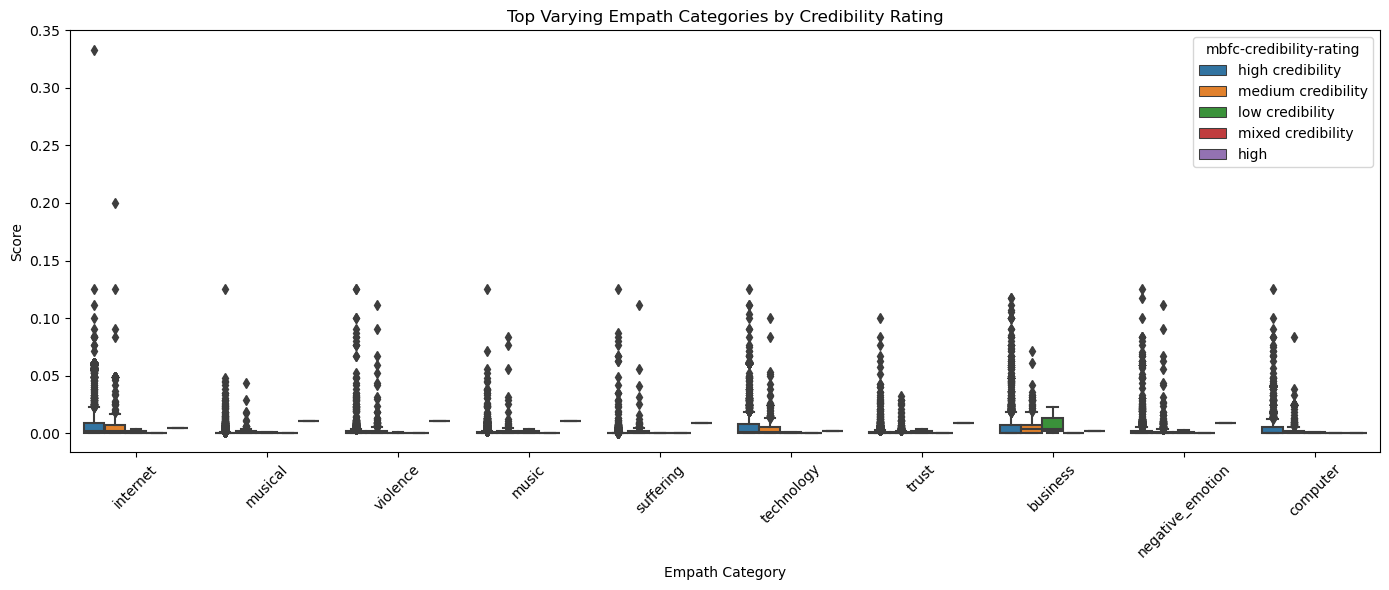

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load merged Empath data with credibility ===
df = pd.read_csv("merged_empath_with_credibility.csv")

# === Group by credibility and compute mean for each category ===
# Drop non-Empath columns (e.g., website_name, credibility label if present)
non_empath_cols = ['website_name', 'mbfc-credibility-rating']
empath_features = [col for col in df.columns if col not in non_empath_cols]

# Group by credibility rating
mean_scores = df.groupby('mbfc-credibility-rating')[empath_features].mean()

# === Compute variance across credibility groups for each category ===
category_variances = mean_scores.var(axis=0)
top_categories = category_variances.sort_values(ascending=False).head(10).index.tolist()

# === Prepare data for plotting ===
plot_data = df[['mbfc-credibility-rating'] + top_categories]
plot_data = plot_data.melt(id_vars='mbfc-credibility-rating', var_name='Empath Category', value_name='Score')

# === Plot ===
plt.figure(figsize=(14, 6))
sns.boxplot(data=plot_data, x='Empath Category', y='Score', hue='mbfc-credibility-rating')
plt.title('Top Varying Empath Categories by Credibility Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

import pandas as pd
import json
import re
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# === Load feature datasets ===
features_df = pd.read_csv("/Thesis/profiling_data/html_features_extended.csv")
empath_df = pd.read_csv("/Thesis/profiling_data/html_features_engineered.csv")

# === Standardise filenames: remove 'www.' prefix ===
features_df['filename'] = features_df['filename'].str.replace(r'^www\.', '', regex=True)
empath_df['filename'] = empath_df['filename'].str.replace(r'^www\.', '', regex=True)

# === Load JSON labels file ===
with open("Thesis/profiling_data/results_expanded_formatted.json", "r") as f:
    json_data = json.load(f)

# === Convert JSON to DataFrame and clean ===
labels_df = pd.DataFrame(json_data)
labels_df['filename'] = labels_df['source_url'].str.strip() + ".html"
labels_df['filename'] = labels_df['filename'].str.replace(r'^www\.', '', regex=True)

# Keep only valid credibility labels
valid_labels = ['low credibility', 'medium credibility', 'high credibility']
labels_df = labels_df[labels_df['mbfc-credibility-rating'].isin(valid_labels)]

labels_df = labels_df[['filename', 'mbfc-credibility-rating']]

# === Merge all datasets on 'filename' ===
merged_df = features_df.merge(empath_df, on='filename').merge(labels_df, on='filename')

# === Encode the credibility label ===
le = LabelEncoder()
merged_df["credibility_encoded"] = le.fit_transform(merged_df["mbfc-credibility-rating"])

# === Drop non-numeric columns and irrelevant fields ===
drop_columns = [
    'filename', 'title', 'canonical_url', 'meta_description', 'meta_keywords',
    'meta_author', 'meta_viewport', 'meta_robots', 'favicon_url',
    'og_title', 'og_description', 'og_image',
    'twitter_title', 'twitter_description', 'twitter_image',
    'h1', 'h2', 'h3', 'text_snippet', 'meta_content_preview',
    'mbfc-credibility-rating'
]

X = merged_df.drop(columns=drop_columns + ['credibility_encoded'], errors='ignore')
y = merged_df['credibility_encoded']

print("\nClass distribution (after merging):")
print(merged_df['mbfc-credibility-rating'].value_counts())

# === Convert everything to numeric and handle missing values ===
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# === Train-test split and scaling ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Apply SMOTE to oversample the minority class with a smaller k_neighbors ===
smote = SMOTE(random_state=42, k_neighbors=1)  # Set k_neighbors to 2 to avoid the error
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# === Logistic Regression as Baseline Model ===
baseline_clf = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    C=1.0,                    # Regularisation strength
    max_iter=1000,            # Ensure convergence
    random_state=42
)

# Fit baseline model
baseline_clf.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_baseline_pred = baseline_clf.predict(X_test_scaled)

# === Evaluate performance ===
print("\n=== Baseline Logistic Regression Results ===")
print(classification_report(y_test, y_baseline_pred, target_names=le.classes_))

# === Confusion matrix plot for baseline ===
conf_matrix_baseline = confusion_matrix(y_test, y_baseline_pred)
sns.heatmap(conf_matrix_baseline, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Baseline Logistic Regression - Confusion Matrix")
plt.show()

# === Hyperparameter Tuning using GridSearchCV ===
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Best parameters found: {grid_search.best_params_}")

# Use the best model from GridSearchCV
clf = grid_search.best_estimator_

# === Train RandomForest model ===
clf.fit(X_train_resampled, y_train_resampled)

# === Evaluate performance ===
y_pred = clf.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# === Confusion matrix plot ===
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# === Feature importance plot ===
feature_importance = pd.Series(clf.feature_importances_, index=X.columns)
feature_importance.nlargest(20).plot(kind='barh', figsize=(10, 8))
plt.title("Top 20 Most Important Features")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import json
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# === Load feature datasets ===
features_df = pd.read_csv("/Thesis/profiling_data/html_features_extended.csv")
empath_df = pd.read_csv("/Thesis/profiling_data/html_features_engineered.csv")

# === Standardise filenames: remove 'www.' prefix ===
features_df['filename'] = features_df['filename'].str.replace(r'^www\.', '', regex=True)
empath_df['filename'] = empath_df['filename'].str.replace(r'^www\.', '', regex=True)

# === Load JSON labels file ===
with open("/Thesis/profiling_data/results_expanded_formatted.json", "r") as f:
    json_data = json.load(f)

# === Convert JSON to DataFrame and clean ===
labels_df = pd.DataFrame(json_data)
labels_df['filename'] = labels_df['source_url'].str.strip() + ".html"
labels_df['filename'] = labels_df['filename'].str.replace(r'^www\.', '', regex=True)

# Keep only valid credibility labels
valid_labels = ['low credibility', 'medium credibility', 'high credibility']
labels_df = labels_df[labels_df['mbfc-credibility-rating'].isin(valid_labels)]

labels_df = labels_df[['filename', 'mbfc-credibility-rating']]

# === Merge all datasets on 'filename' ===
merged_df = features_df.merge(empath_df, on='filename').merge(labels_df, on='filename')

# === Encode the credibility label ===
le = LabelEncoder()
merged_df["credibility_encoded"] = le.fit_transform(merged_df["mbfc-credibility-rating"])

# === Drop non-numeric columns and irrelevant fields ===
drop_columns = [
    'filename', 'title', 'canonical_url', 'meta_description', 'meta_keywords',
    'meta_author', 'meta_viewport', 'meta_robots', 'favicon_url',
    'og_title', 'og_description', 'og_image',
    'twitter_title', 'twitter_description', 'twitter_image',
    'h1', 'h2', 'h3', 'text_snippet', 'meta_content_preview',
    'mbfc-credibility-rating'
]

X = merged_df.drop(columns=drop_columns + ['credibility_encoded'], errors='ignore')
y = merged_df['credibility_encoded']

print("\nClass distribution (after merging):")
print(merged_df['mbfc-credibility-rating'].value_counts())

# === Convert everything to numeric and handle missing values ===
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# === Train-test split and scaling ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Apply SMOTE to oversample the minority class with a smaller k_neighbors ===
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# === Hyperparameter Tuning using GridSearchCV ===
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define XGBoost classifier
clf = xgb.XGBClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Best parameters found: {grid_search.best_params_}")

# Use the best model from GridSearchCV
clf = grid_search.best_estimator_

# === Train XGBoost model ===
clf.fit(X_train_resampled, y_train_resampled)

# === Evaluate performance ===
y_pred = clf.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# === Confusion matrix plot ===
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# === Feature importance plot ===
feature_importance = pd.Series(clf.feature_importances_, index=X.columns)
feature_importance.nlargest(20).plot(kind='barh', figsize=(10, 8))
plt.title("Top 20 Most Important Features")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Best parameters found: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

📋 Classification Report (Logistic Regression - Binary):
              precision    recall  f1-score   support

    non-high       0.27      0.57      0.37       130
        high       0.91      0.73      0.81       734

    accuracy                           0.71       864
   macro avg       0.59      0.65      0.59       864
weighted avg       0.81      0.71      0.74       864



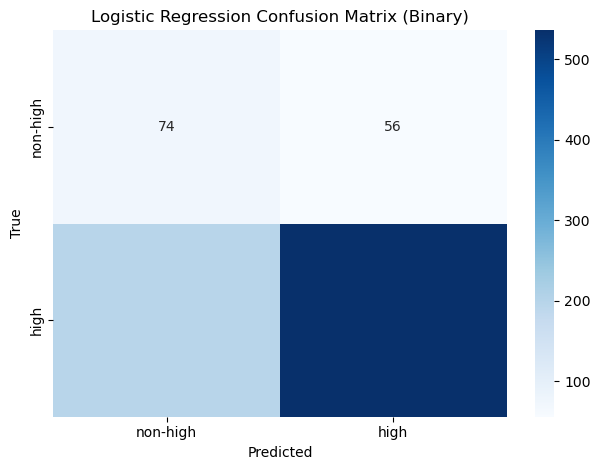

🎯 ROC AUC Score: 0.7161


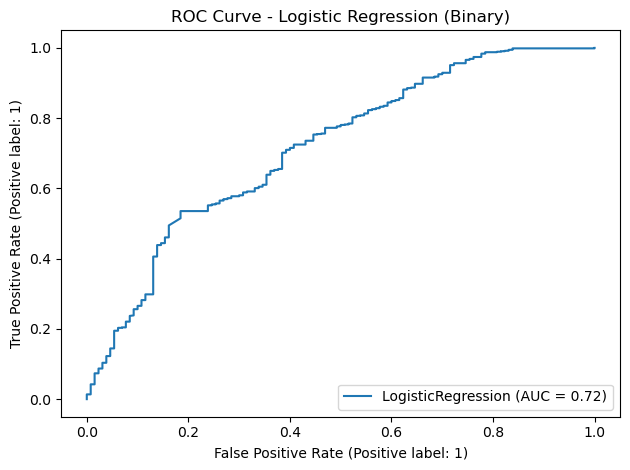

In [23]:
import pandas as pd
import json
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# === Load datasets ===
features_df = pd.read_csv("/Thesis/profiling_data/html_features_extended.csv")
empath_df = pd.read_csv("/Thesis/profiling_data/html_features_engineered.csv")

features_df['filename'] = features_df['filename'].str.replace(r'^www\.', '', regex=True)
empath_df['filename'] = empath_df['filename'].str.replace(r'^www\.', '', regex=True)

with open("/Thesis/profiling_data/results_expanded_formatted.json", "r") as f:
    json_data = json.load(f)

labels_df = pd.DataFrame(json_data)
labels_df['filename'] = labels_df['source_url'].str.strip() + ".html"
labels_df['filename'] = labels_df['filename'].str.replace(r'^www\.', '', regex=True)

valid_labels = ['low credibility', 'medium credibility', 'high credibility']
labels_df = labels_df[labels_df['mbfc-credibility-rating'].isin(valid_labels)]
labels_df['binary_label'] = labels_df['mbfc-credibility-rating'].apply(lambda x: 1 if x == 'high credibility' else 0)
labels_df = labels_df[['filename', 'binary_label']]

merged_df = features_df.merge(empath_df, on='filename').merge(labels_df, on='filename')

drop_columns = [
    'filename', 'title', 'canonical_url', 'meta_description', 'meta_keywords',
    'meta_author', 'meta_viewport', 'meta_robots', 'favicon_url',
    'og_title', 'og_description', 'og_image',
    'twitter_title', 'twitter_description', 'twitter_image',
    'h1', 'h2', 'h3', 'text_snippet', 'meta_content_preview'
]

X = merged_df.drop(columns=drop_columns + ['binary_label'], errors='ignore')
y = merged_df['binary_label']

X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# === Train-test split and scaling ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Grid Search for Logistic Regression ===
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # supports both l1 and l2
    'class_weight': ['balanced']
}

logreg = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_logreg = grid_search.best_estimator_
print(f"✅ Best parameters found: {grid_search.best_params_}")

# === Evaluate best model on test set ===
y_pred = best_logreg.predict(X_test_scaled)
y_prob = best_logreg.predict_proba(X_test_scaled)[:, 1]

print("\n📋 Classification Report (Logistic Regression - Binary):")
print(classification_report(y_test, y_pred, target_names=["non-high", "high"]))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["non-high", "high"], yticklabels=["non-high", "high"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression Confusion Matrix (Binary)")
plt.tight_layout()
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"🎯 ROC AUC Score: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(best_logreg, X_test_scaled, y_test)
plt.title("ROC Curve - Logistic Regression (Binary)")
plt.tight_layout()
plt.show()


             Feature  Coefficient  Abs_Coefficient
4          num_lists     1.091569         1.091569
12        char_count     0.683692         0.683692
13  reading_time_min    -0.681659         0.681659
11        word_count    -0.569832         0.569832
6        num_scripts    -0.548068         0.548068
8        total_links    -0.234026         0.234026
9     internal_links    -0.234026         0.234026
3           num_divs     0.200163         0.200163
2     num_paragraphs     0.165152         0.165152
5         num_images    -0.130834         0.130834
0       title_length     0.071311         0.071311
7         num_styles     0.065171         0.065171
1          page_lang     0.000000         0.000000
10    external_links     0.000000         0.000000


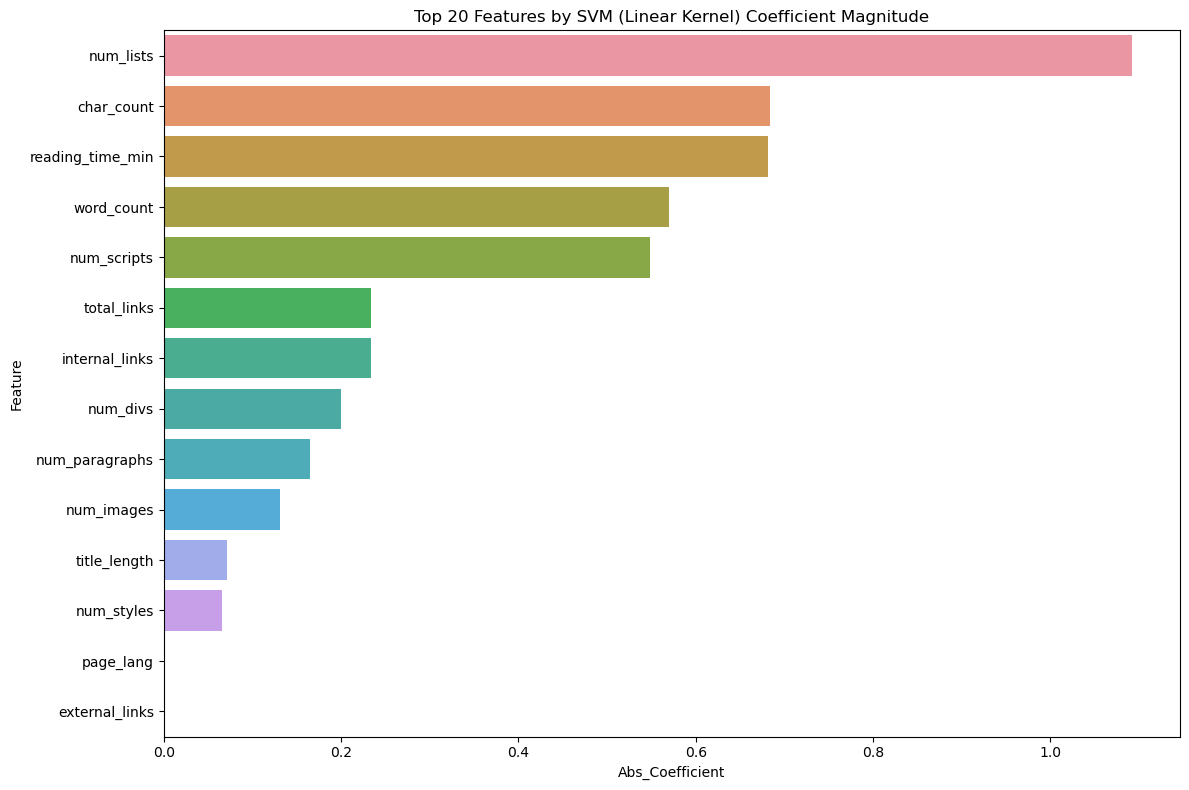

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === Load your data ===
df = pd.read_csv("/Thesis/profiling_data/html_features_with_labels.csv")

# === Encode binary label ===
df['label'] = df['mbfc-credibility-rating'].map({
    'high credibility': 1,
    'medium credibility': 0,
    'low credibility': 0
})
df = df[df['label'].notna()]

# === Drop leaking/non-numeric columns ===
drop_columns = [
    'filename', 'title', 'canonical_url', 'meta_description', 'meta_keywords',
    'meta_author', 'meta_viewport', 'meta_robots', 'favicon_url',
    'og_title', 'og_description', 'og_image',
    'twitter_title', 'twitter_description', 'twitter_image',
    'h1', 'h2', 'h3', 'text_snippet', 'domain', 'source_url',
    'mbfc-credibility-rating'
]

X = df.drop(columns=drop_columns + ['label'], errors='ignore')
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['label'].astype(int)

# === Split and scale ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Train Linear SVM ===
svm_model = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# === Extract and plot feature importances ===
coefficients = svm_model.coef_[0]
svm_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Abs_Coefficient': abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# === Display and plot top 20 ===
print(svm_feature_importance.head(20))

plt.figure(figsize=(12, 8))
sns.barplot(x='Abs_Coefficient', y='Feature', data=svm_feature_importance.head(20))
plt.title("Top 20 Features by SVM (Linear Kernel) Coefficient Magnitude")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss

# === Calibrate the logistic regression model ===
calibrated_clf = CalibratedClassifierCV(base_estimator=best_logreg, method='sigmoid', cv=5)
calibrated_clf.fit(X_train_scaled, y_train)

# Predict probabilities
y_prob_uncalibrated = best_logreg.predict_proba(X_test_scaled)[:, 1]
y_prob_calibrated = calibrated_clf.predict_proba(X_test_scaled)[:, 1]

# === Compare Brier scores ===
brier_uncalibrated = brier_score_loss(y_test, y_prob_uncalibrated)
brier_calibrated = brier_score_loss(y_test, y_prob_calibrated)

print(f"\n📉 Brier Score (Uncalibrated): {brier_uncalibrated:.4f}")
print(f"📈 Brier Score (Calibrated): {brier_calibrated:.4f}")

# === Calibration plots ===
plt.figure(figsize=(10, 6))

# Plot calibration curve for uncalibrated model
prob_true_uncal, prob_pred_uncal = calibration_curve(y_test, y_prob_uncalibrated, n_bins=20)
plt.plot(prob_pred_uncal, prob_true_uncal, marker='o', label='Uncalibrated')

# Plot calibration curve for calibrated model
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_calibrated, n_bins=20)
plt.plot(prob_pred_cal, prob_true_cal, marker='s', label='Calibrated (Sigmoid)')

# Reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

# === 1. Load merged data with credibility rating ===
df = pd.read_csv('/Thesis/profiling_data/html_features_with_labels.csv')

# === 2. Clean: drop rows with missing or bad data ===
df = df[df['mbfc-credibility-rating'].notna()]
df = df[df['text_snippet'].notna()]
df = df[df['text_snippet'].str.strip() != ""]

# === 3. Encode binary label: high=1, others=0 ===
df['label'] = df['mbfc-credibility-rating'].map({
    'high credibility': 1,
    'medium credibility': 0,
    'low credibility': 0
})
df = df[df['label'].notna()]  # drop anything unmapped

# === 4. TF-IDF vectorisation ===
tfidf = TfidfVectorizer(max_features=300, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['text_snippet'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=df.index)

# === 5. Prepare structural features and drop leaked info ===
drop_cols = [
    'filename', 'domain', 'source_url', 'mbfc-credibility-rating', 'text_snippet', 'canonical_url',
    'meta_description', 'meta_keywords', 'meta_author', 'og_title', 'og_description', 'og_image',
    'twitter_title', 'twitter_description', 'twitter_image', 'h1', 'h2', 'h3', 'title', 'label'  # <- drop label!
]
numeric_features = df.drop(columns=drop_cols, errors='ignore')

# Combine features
X = pd.concat([numeric_features, tfidf_df], axis=1)
X = X.select_dtypes(include=[np.number])  # SMOTE only supports numeric input
y = df['label'].astype(int)

# === 6. Shuffle, Split, and Balance ===
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# === 7. Scale features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# === 8. Train and evaluate models ===
def train_and_report(model, name):
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n{name} CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    if y_prob is not None:
        print(f"{name} ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Logistic Regression
log_model = LogisticRegression(C=0.01, class_weight='balanced', penalty='l2', max_iter=1000)
train_and_report(log_model, "Logistic Regression")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
train_and_report(rf_model, "Random Forest")

# Support Vector Machine
svm_model = SVC(C=10, kernel='linear', class_weight='balanced', probability=False, random_state=42)
train_and_report(svm_model, "SVM (Linear)")



Logistic Regression CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.43      0.84      0.57       129
           1       0.97      0.80      0.88       733

    accuracy                           0.81       862
   macro avg       0.70      0.82      0.73       862
weighted avg       0.89      0.81      0.83       862

Confusion Matrix:
[[109  20]
 [143 590]]
Logistic Regression ROC AUC: 0.9028

Random Forest CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       129
           1       0.93      0.94      0.93       733

    accuracy                           0.89       862
   macro avg       0.78      0.77      0.78       862
weighted avg       0.89      0.89      0.89       862

Confusion Matrix:
[[ 79  50]
 [ 46 687]]
Random Forest ROC AUC: 0.9079



Logistic Regression CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.43      0.84      0.57       129
           1       0.97      0.80      0.88       733

    accuracy                           0.81       862
   macro avg       0.70      0.82      0.73       862
weighted avg       0.89      0.81      0.83       862

Logistic Regression ROC AUC: 0.9028

Raw Confusion Matrix (Logistic Regression):
 [[109  20]
 [143 590]]


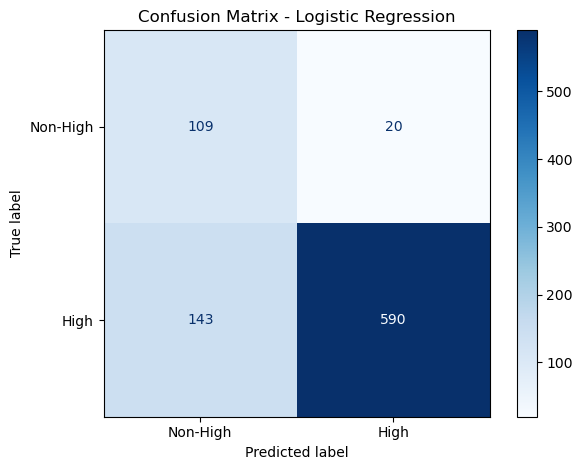


Normalized Confusion Matrix (Logistic Regression):
 [[0.845  0.155 ]
 [0.1951 0.8049]]


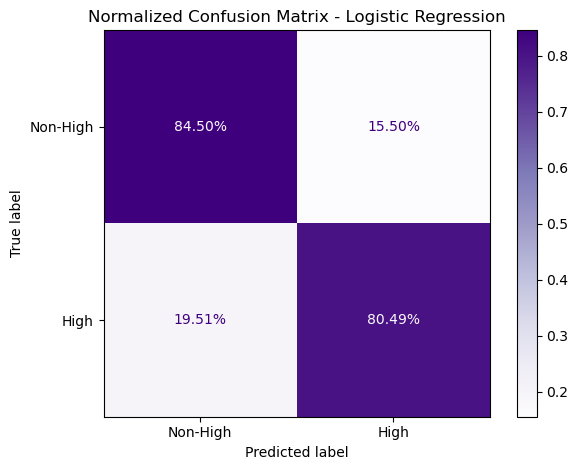


Random Forest CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       129
           1       0.93      0.94      0.93       733

    accuracy                           0.89       862
   macro avg       0.78      0.77      0.78       862
weighted avg       0.89      0.89      0.89       862

Random Forest ROC AUC: 0.9079

Raw Confusion Matrix (Random Forest):
 [[ 79  50]
 [ 46 687]]


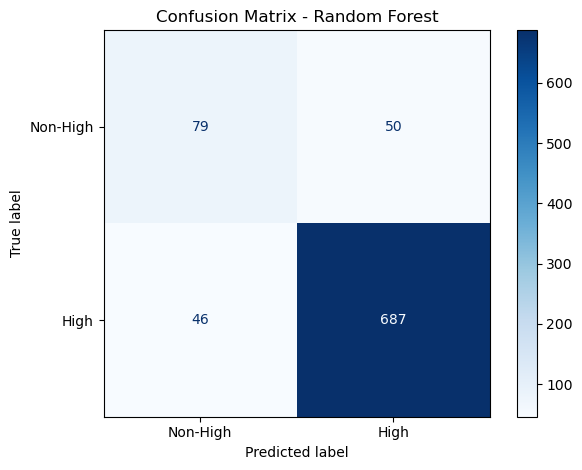


Normalized Confusion Matrix (Random Forest):
 [[0.6124 0.3876]
 [0.0628 0.9372]]


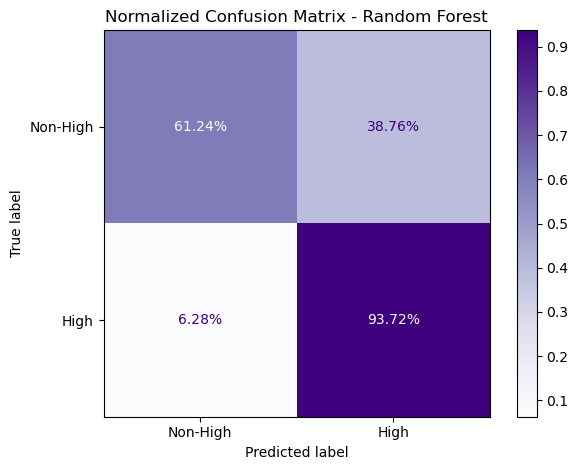

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.metrics import ConfusionMatrixDisplay

# === 1. Load data ===
df = pd.read_csv('/Thesis/profiling_data/html_features_with_labels.csv')

# === 2. Clean ===
df = df[df['mbfc-credibility-rating'].notna()]
df = df[df['text_snippet'].notna()]
df = df[df['text_snippet'].str.strip() != ""]

# === 3. Encode binary label: high = 1, others = 0 ===
df['label'] = df['mbfc-credibility-rating'].map({
    'high credibility': 1,
    'medium credibility': 0,
    'low credibility': 0
})
df = df[df['label'].notna()]

# === 4. TF-IDF vectorisation ===
tfidf = TfidfVectorizer(max_features=300, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['text_snippet'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=df.index)

# === 5. Structural features ===
drop_cols = [
    'filename', 'domain', 'source_url', 'mbfc-credibility-rating', 'text_snippet', 'canonical_url',
    'meta_description', 'meta_keywords', 'meta_author', 'og_title', 'og_description', 'og_image',
    'twitter_title', 'twitter_description', 'twitter_image', 'h1', 'h2', 'h3', 'title', 'label'
]
numeric_features = df.drop(columns=drop_cols, errors='ignore')

X = pd.concat([numeric_features, tfidf_df], axis=1)
X = X.select_dtypes(include=[np.number])
y = df['label'].astype(int)

# === 6. Shuffle, Split, SMOTE ===
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# === 7. Scale ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# === 8. Evaluation function with enlarged matrix display ===

def train_and_report(model, name):
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\n{name} CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred))
    print(f"{name} ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

    # === Raw confusion matrix ===
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    print(f"\nRaw Confusion Matrix ({name}):\n", cm)

    labels = ["Non-High", "High"]

    # === Plot count confusion matrix ===
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

    # === Normalized confusion matrix ===
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(f"\nNormalized Confusion Matrix ({name}):\n", np.round(cm_normalized, 4))

    disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels)
    disp_normalized.plot(cmap=plt.cm.Purples, values_format='.2%')
    plt.title(f"Normalized Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()


# === 9. Train models ===
log_model = LogisticRegression(C=0.01, class_weight='balanced', penalty='l2', max_iter=1000)
train_and_report(log_model, "Logistic Regression")

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
train_and_report(rf_model, "Random Forest")


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# === Load data ===
df = pd.read_csv('/Thesis/profiling_data/html_features_with_labels.csv')
df = df[df['mbfc-credibility-rating'].notna()]
df = df[df['text_snippet'].notna()]
df = df[df['text_snippet'].str.strip() != ""]

# === Label encoding ===
df['label'] = df['mbfc-credibility-rating'].map({
    'high credibility': 1,
    'medium credibility': 0,
    'low credibility': 0
})
df = df.dropna(subset=['label'])  # Remove rows where mapping failed
df['label'] = df['label'].astype(int)

# === TF-IDF vectorisation ===
tfidf = TfidfVectorizer(max_features=300, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['text_snippet'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=df.index)

# === Drop metadata columns ===
drop_cols = [
    'filename', 'domain', 'source_url', 'mbfc-credibility-rating', 'text_snippet', 'canonical_url',
    'meta_description', 'meta_keywords', 'meta_author', 'og_title', 'og_description', 'og_image',
    'twitter_title', 'twitter_description', 'twitter_image', 'h1', 'h2', 'h3', 'title', 'label'
]
numeric_features = df.drop(columns=drop_cols, errors='ignore')
X = pd.concat([numeric_features, tfidf_df], axis=1)
X = X.select_dtypes(include=[np.number]).fillna(0)
y = df['label'].astype(int)

# === Split and scale ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Logistic Regression feature importance ===
log_model = LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000)
log_model.fit(X_train_scaled, y_train)
log_coeffs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0],
    'Abs_Coefficient': np.abs(log_model.coef_[0])
}).sort_values(by='Abs_Coefficient', ascending=False)
print("Top 20 Logistic Regression Features:\n", log_coeffs.head(20))

# === Random Forest feature importance ===
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTop 20 Random Forest Features:\n", rf_importance.head(20))

# === SVM feature importance ===
svm_model = SVC(C=10, kernel='linear', class_weight='balanced')
svm_model.fit(X_train_scaled, y_train)
svm_coeffs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': svm_model.coef_[0],
    'Abs_Coefficient': np.abs(svm_model.coef_[0])
}).sort_values(by='Abs_Coefficient', ascending=False)
print("\nTop 20 SVM Features:\n", svm_coeffs.head(20))


Top 20 Logistic Regression Features:
          Feature  Coefficient  Abs_Coefficient
291  unavailable     0.289107         0.289107
274       submit     0.276793         0.276793
163        local     0.263361         0.263361
3      num_lists     0.253754         0.253754
231       region     0.250593         0.250593
265       sports     0.244608         0.244608
167         main     0.212830         0.212830
184  newsletters     0.210334         0.210334
159   lifestyles     0.200898         0.200898
126   guidelines     0.191931         0.191931
224        query     0.183844         0.183844
79          data     0.180065         0.180065
312      youtube     0.171215         0.171215
244     schedule     0.169558         0.169558
183   newsletter     0.169406         0.169406
238      results     0.168359         0.168359
61         close     0.163632         0.163632
58   classifieds     0.156776         0.156776
189   obituaries     0.155009         0.155009
37          arts     0


=== Baseline Logistic Regression Results (No SMOTE) ===
              precision    recall  f1-score   support

    non-high       0.27      0.58      0.37       130
        high       0.91      0.72      0.80       734

    accuracy                           0.70       864
   macro avg       0.59      0.65      0.59       864
weighted avg       0.81      0.70      0.74       864



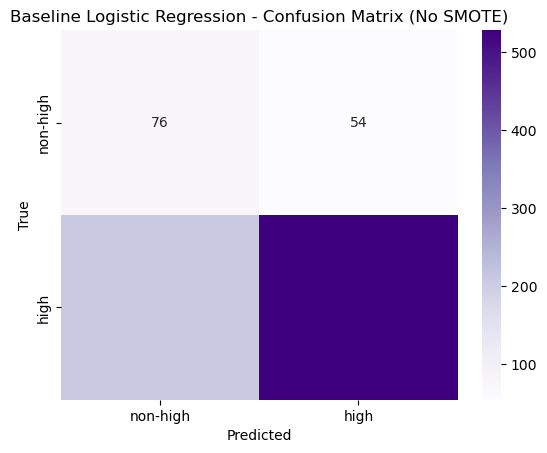


Best parameters found: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}

=== Random Forest Classification Report (No SMOTE) ===
              precision    recall  f1-score   support

    non-high       0.82      0.25      0.39       130
        high       0.88      0.99      0.93       734

    accuracy                           0.88       864
   macro avg       0.85      0.62      0.66       864
weighted avg       0.87      0.88      0.85       864



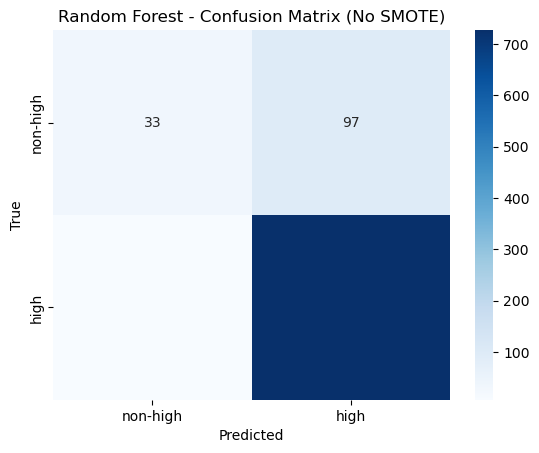

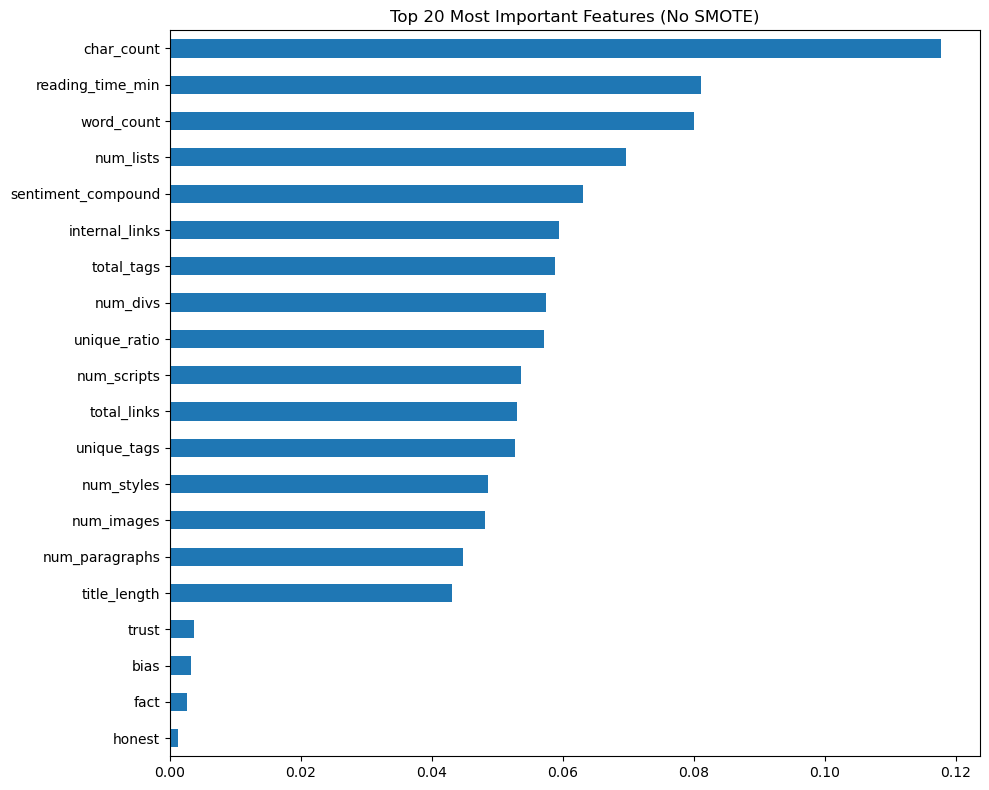

In [13]:

import pandas as pd
import json
import re
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Load feature datasets ===
features_df = pd.read_csv("/Thesis/profiling_data/html_features_extended.csv")
empath_df = pd.read_csv("/Thesis/profiling_data/html_features_engineered.csv")

# === Standardise filenames: remove 'www.' prefix ===
features_df['filename'] = features_df['filename'].str.replace(r'^www\.', '', regex=True)
empath_df['filename'] = empath_df['filename'].str.replace(r'^www\.', '', regex=True)

# === Load JSON labels file ===
with open("/Thesis/profiling_data/results_expanded_formatted.json", "r") as f:
    json_data = json.load(f)

labels_df = pd.DataFrame(json_data)
labels_df['filename'] = labels_df['source_url'].str.strip() + ".html"
labels_df['filename'] = labels_df['filename'].str.replace(r'^www\.', '', regex=True)

# Keep only valid credibility labels
valid_labels = ['low credibility', 'medium credibility', 'high credibility']
labels_df = labels_df[labels_df['mbfc-credibility-rating'].isin(valid_labels)]
labels_df = labels_df[['filename', 'mbfc-credibility-rating']]

# === Merge all datasets on 'filename' ===
merged_df = features_df.merge(empath_df, on='filename').merge(labels_df, on='filename')

# === Create binary labels: 1 = high credibility, 0 = non-high ===
merged_df['credibility_binary'] = merged_df['mbfc-credibility-rating'].apply(
    lambda x: 1 if x == 'high credibility' else 0
)

# === Drop non-numeric and irrelevant columns ===
drop_columns = [
    'filename', 'title', 'canonical_url', 'meta_description', 'meta_keywords',
    'meta_author', 'meta_viewport', 'meta_robots', 'favicon_url',
    'og_title', 'og_description', 'og_image',
    'twitter_title', 'twitter_description', 'twitter_image',
    'h1', 'h2', 'h3', 'text_snippet', 'meta_content_preview',
    'mbfc-credibility-rating'
]

X = merged_df.drop(columns=drop_columns + ['credibility_binary'], errors='ignore')
y = merged_df['credibility_binary']

# === Convert everything to numeric and handle missing values ===
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# === Train-test split and scaling ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Logistic Regression as Baseline Model ===
baseline_clf = LogisticRegression(class_weight='balanced', C=1.0, max_iter=1000, random_state=42)
baseline_clf.fit(X_train_scaled, y_train)
y_baseline_pred = baseline_clf.predict(X_test_scaled)

print("\n=== Baseline Logistic Regression Results (No SMOTE) ===")
print(classification_report(y_test, y_baseline_pred, target_names=['non-high', 'high']))

conf_matrix_baseline = confusion_matrix(y_test, y_baseline_pred)
sns.heatmap(conf_matrix_baseline, annot=True, fmt='d', cmap='Purples',
            xticklabels=['non-high', 'high'], yticklabels=['non-high', 'high'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Baseline Logistic Regression - Confusion Matrix (No SMOTE)")
plt.show()

# === Random Forest Classifier with GridSearch ===
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")

clf = grid_search.best_estimator_
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("\n=== Random Forest Classification Report (No SMOTE) ===")
print(classification_report(y_test, y_pred, target_names=['non-high', 'high']))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['non-high', 'high'], yticklabels=['non-high', 'high'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest - Confusion Matrix (No SMOTE)")
plt.show()

# === Feature importance plot ===
feature_importance = pd.Series(clf.feature_importances_, index=X.columns)
feature_importance.nlargest(20).plot(kind='barh', figsize=(10, 8))
plt.title("Top 20 Most Important Features (No SMOTE)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()



=== Random Forest Classification Report (TF-IDF + HTML + Empath) ===
              precision    recall  f1-score   support

    non-high       0.52      0.27      0.35        41
        high       0.84      0.94      0.89       167

    accuracy                           0.81       208
   macro avg       0.68      0.60      0.62       208
weighted avg       0.78      0.81      0.78       208

ROC AUC Score: 0.8274


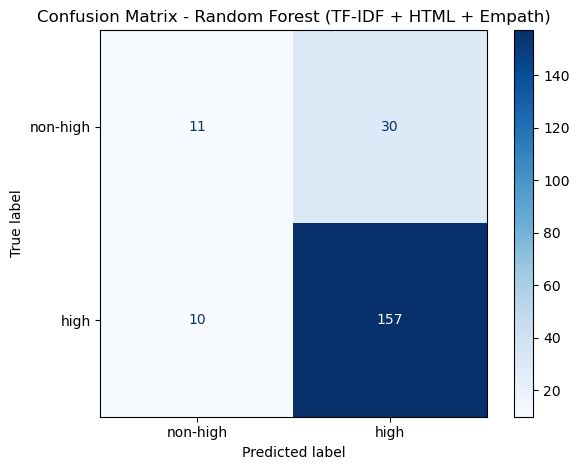

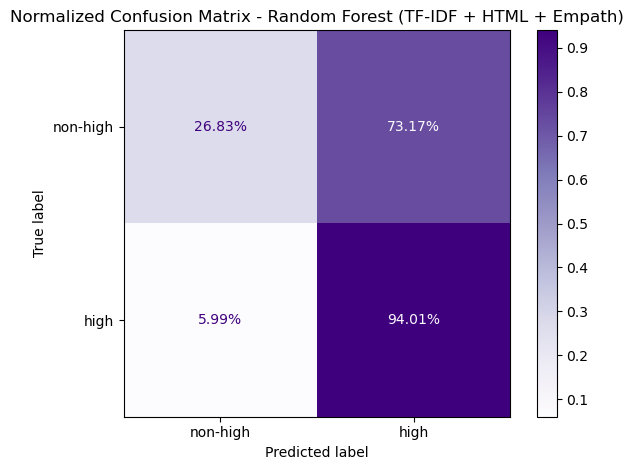

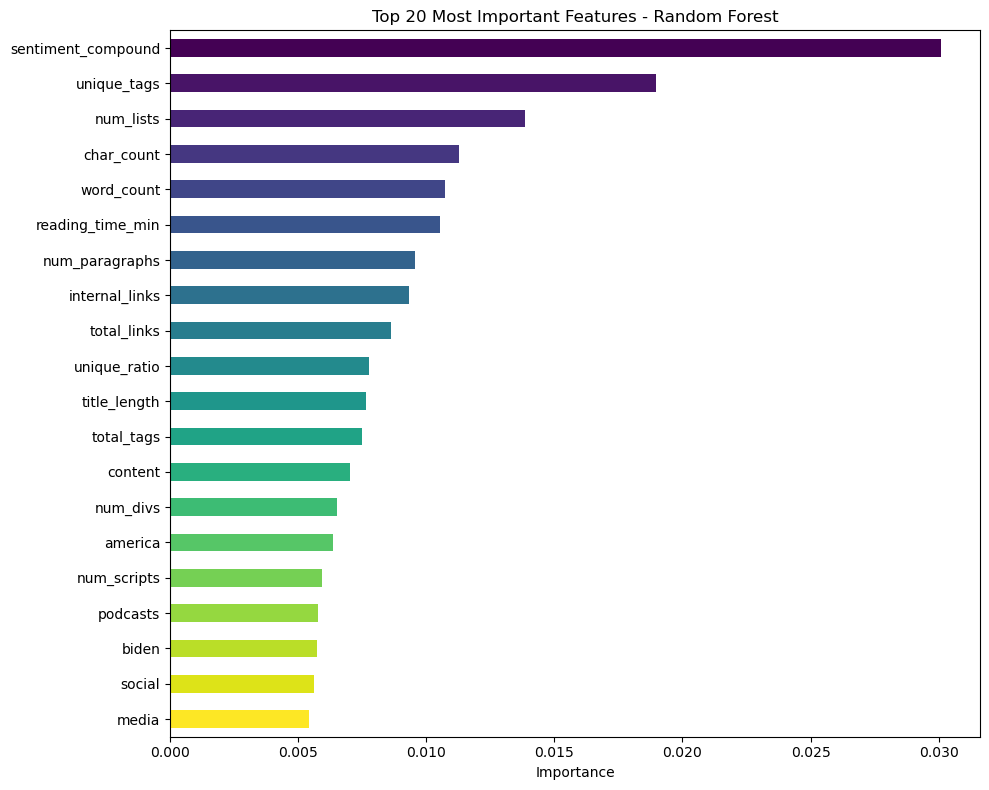

In [20]:

import pandas as pd
import numpy as np
import os
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# === Load metadata and engineered features ===
html_features = pd.read_csv("/Thesis/profiling_data/html_features_extended.csv")
empath_features = pd.read_csv("/Thesis/profiling_data/html_features_engineered.csv")

# === Clean filename ===
html_features["filename"] = html_features["filename"].str.replace(r"^www\.", "", regex=True)
empath_features["filename"] = empath_features["filename"].str.replace(r"^www\.", "", regex=True)

# === Load JSON labels ===
with open("/Thesis/profiling_data/results_expanded_formatted.json", "r") as f:
    labels = json.load(f)

labels_df = pd.DataFrame(labels)
labels_df["filename"] = labels_df["source_url"].str.strip() + ".html"
labels_df["filename"] = labels_df["filename"].str.replace(r"^www\.", "", regex=True)
labels_df = labels_df[labels_df["mbfc-credibility-rating"].isin(["low credibility", "medium credibility", "high credibility"])]
labels_df = labels_df[["filename", "mbfc-credibility-rating"]]

# === Load text files ===
text_folder = "/Thesis/profiling_data/extracted_texts"
text_data = {}
for fname in os.listdir(text_folder):
    if fname.endswith(".txt"):
        with open(os.path.join(text_folder, fname), "r", encoding="utf-8", errors="ignore") as f:
            text_data[fname.replace(".txt", ".html")] = f.read()

text_df = pd.DataFrame(list(text_data.items()), columns=["filename", "text"])

# === Merge all data sources ===
merged = html_features.merge(empath_features, on="filename").merge(labels_df, on="filename").merge(text_df, on="filename")

# === Binary label: 1 for high, 0 for non-high ===
merged["label"] = merged["mbfc-credibility-rating"].apply(lambda x: 1 if x == "high credibility" else 0)

# === TF-IDF vectorisation ===
tfidf = TfidfVectorizer(
    max_features=2000,
    stop_words="english",
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.85
)

tfidf_matrix = tfidf.fit_transform(merged["text"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=merged.index)

# === Drop non-numeric/unwanted fields ===
drop_cols = [
    "filename", "title", "canonical_url", "meta_description", "meta_keywords", "meta_author", "meta_viewport",
    "meta_robots", "favicon_url", "og_title", "og_description", "og_image", "twitter_title", "twitter_description",
    "twitter_image", "h1", "h2", "h3", "text_snippet", "meta_content_preview", "mbfc-credibility-rating", "text"
]
numeric_features = merged.drop(columns=drop_cols + ["label"], errors="ignore")

# === Combine features ===
X = pd.concat([numeric_features, tfidf_df], axis=1)
X = X.select_dtypes(include=[np.number])
y = merged["label"]

# === Train-test split and preprocessing ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# === Train Random Forest with GridSearch ===
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train_resampled)
best_rf = grid.best_estimator_

# === Evaluate ===
y_pred = best_rf.predict(X_test_scaled)
y_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

report = classification_report(y_test, y_pred, target_names=["non-high", "high"])
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# === Print evaluation results ===
print("\n=== Random Forest Classification Report (TF-IDF + HTML + Empath) ===")
print(report)
print(f"ROC AUC Score: {roc_auc:.4f}")

# === Confusion matrix ===
labels = ["non-high", "high"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest (TF-IDF + HTML + Empath)")
plt.tight_layout()
plt.show()

# === Normalized confusion matrix ===
conf_matrix_norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_norm, display_labels=labels)
disp_norm.plot(cmap=plt.cm.Purples, values_format=".2%")
plt.title("Normalized Confusion Matrix - Random Forest (TF-IDF + HTML + Empath)")
plt.tight_layout()
plt.show()

# === Feature importance ===
importances = pd.Series(best_rf.feature_importances_, index=X.columns).nlargest(20)

importances.plot(kind="barh", figsize=(10, 8), color=plt.cm.viridis(np.linspace(0, 1, 20)))
plt.title("Top 20 Most Important Features - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()




=== Logistic Regression Classification Report (TF-IDF + HTML + Empath) ===
              precision    recall  f1-score   support

    non-high       0.40      0.49      0.44        41
        high       0.87      0.82      0.84       167

    accuracy                           0.75       208
   macro avg       0.63      0.65      0.64       208
weighted avg       0.78      0.75      0.76       208

ROC AUC Score: 0.7348


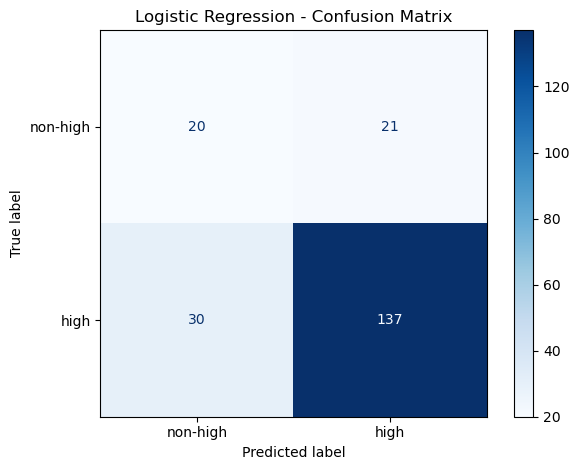

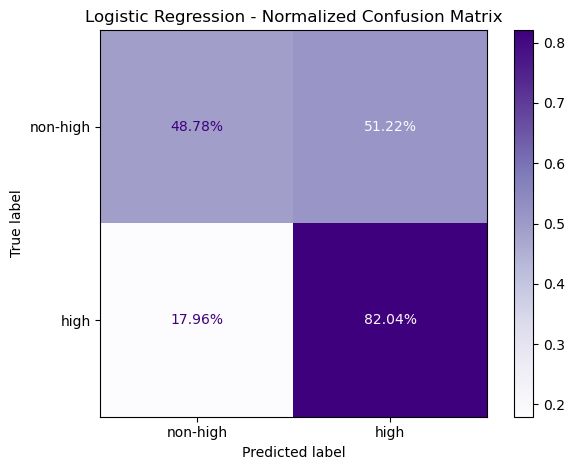

In [22]:
import pandas as pd
import numpy as np
import os
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# === Load datasets ===
html_features = pd.read_csv("/Thesis/profiling_data/html_features_extended.csv")
empath_features = pd.read_csv("/Thesis/profiling_data/html_features_engineered.csv")

html_features["filename"] = html_features["filename"].str.replace(r"^www\.", "", regex=True)
empath_features["filename"] = empath_features["filename"].str.replace(r"^www\.", "", regex=True)

with open("Thesis/profiling_data/results_expanded_formatted.json", "r") as f:
    labels = json.load(f)

labels_df = pd.DataFrame(labels)
labels_df["filename"] = labels_df["source_url"].str.strip() + ".html"
labels_df["filename"] = labels_df["filename"].str.replace(r"^www\.", "", regex=True)
labels_df = labels_df[labels_df["mbfc-credibility-rating"].isin(["low credibility", "medium credibility", "high credibility"])]
labels_df = labels_df[["filename", "mbfc-credibility-rating"]]

# === Load and merge text files ===
text_folder = "/Thesis/profiling_data/extracted_texts"
text_data = {}
for fname in os.listdir(text_folder):
    if fname.endswith(".txt"):
        with open(os.path.join(text_folder, fname), "r", encoding="utf-8", errors="ignore") as f:
            text_data[fname.replace(".txt", ".html")] = f.read()

text_df = pd.DataFrame(list(text_data.items()), columns=["filename", "text"])

# === Merge all sources ===
merged = html_features.merge(empath_features, on="filename").merge(labels_df, on="filename").merge(text_df, on="filename")

# === Binary label ===
merged["label"] = merged["mbfc-credibility-rating"].apply(lambda x: 1 if x == "high credibility" else 0)

# === TF-IDF vectorisation ===
tfidf = TfidfVectorizer(max_features=1000, stop_words="english", ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(merged["text"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=merged.index)

# === Drop unwanted columns ===
drop_cols = [
    "filename", "title", "canonical_url", "meta_description", "meta_keywords", "meta_author", "meta_viewport",
    "meta_robots", "favicon_url", "og_title", "og_description", "og_image", "twitter_title", "twitter_description",
    "twitter_image", "h1", "h2", "h3", "text_snippet", "meta_content_preview", "mbfc-credibility-rating", "text"
]
numeric_features = merged.drop(columns=drop_cols + ["label"], errors="ignore")

# === Combine features ===
X = pd.concat([numeric_features, tfidf_df], axis=1)
X = X.select_dtypes(include=[np.number])
y = merged["label"]

# === Split and scale ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# === Logistic Regression Classifier ===
logreg = LogisticRegression(class_weight="balanced", C=1.0, max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train_resampled)

# === Evaluate ===
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

print("\n=== Logistic Regression Classification Report (TF-IDF + HTML + Empath) ===")
print(classification_report(y_test, y_pred, target_names=["non-high", "high"]))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# === Confusion Matrix ===
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["non-high", "high"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.show()

# === Normalized Confusion Matrix ===
conf_matrix_norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_norm, display_labels=["non-high", "high"])
disp_norm.plot(cmap=plt.cm.Purples, values_format=".2%")
plt.title("Logistic Regression - Normalized Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import os
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_importance

# === Load datasets ===
html_features = pd.read_csv("/Thesis/profiling_data/html_features_extended.csv")
empath_features = pd.read_csv("/Thesis/profiling_data/html_features_engineered.csv")

html_features["filename"] = html_features["filename"].str.replace(r"^www\.", "", regex=True)
empath_features["filename"] = empath_features["filename"].str.replace(r"^www\.", "", regex=True)

with open("/Thesis/profiling_data/results_expanded_formatted.json", "r") as f:
    labels = json.load(f)

labels_df = pd.DataFrame(labels)
labels_df["filename"] = labels_df["source_url"].str.strip() + ".html"
labels_df["filename"] = labels_df["filename"].str.replace(r"^www\.", "", regex=True)
labels_df = labels_df[labels_df["mbfc-credibility-rating"].isin(["low credibility", "medium credibility", "high credibility"])]
labels_df = labels_df[["filename", "mbfc-credibility-rating"]]

# === Load and merge text files ===
text_folder = "/Thesis/profiling_data/extracted_texts"
text_data = {}
for fname in os.listdir(text_folder):
    if fname.endswith(".txt"):
        with open(os.path.join(text_folder, fname), "r", encoding="utf-8", errors="ignore") as f:
            text_data[fname.replace(".txt", ".html")] = f.read()

text_df = pd.DataFrame(list(text_data.items()), columns=["filename", "text"])

# === Merge all sources ===
merged = html_features.merge(empath_features, on="filename").merge(labels_df, on="filename").merge(text_df, on="filename")

# === Binary label ===
merged["label"] = merged["mbfc-credibility-rating"].apply(lambda x: 1 if x == "high credibility" else 0)

# === TF-IDF vectorisation ===
tfidf = TfidfVectorizer(max_features=1000, stop_words="english", ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(merged["text"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=merged.index)

# === Drop unwanted columns ===
drop_cols = [
    "filename", "title", "canonical_url", "meta_description", "meta_keywords", "meta_author", "meta_viewport",
    "meta_robots", "favicon_url", "og_title", "og_description", "og_image", "twitter_title", "twitter_description",
    "twitter_image", "h1", "h2", "h3", "text_snippet", "meta_content_preview", "mbfc-credibility-rating", "text"
]
numeric_features = merged.drop(columns=drop_cols + ["label"], errors="ignore")

# === Combine features ===
X = pd.concat([numeric_features, tfidf_df], axis=1)
X = X.select_dtypes(include=[np.number])
y = merged["label"]

# === Split and scale ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# === XGBoost Classifier ===
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train_scaled, y_train_resampled)

# === Evaluation ===
y_pred = xgb.predict(X_test_scaled)
y_proba = xgb.predict_proba(X_test_scaled)[:, 1]

print("\n=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["non-high", "high"]))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# === Feature Importance Plot (Top 20 by gain) ===
importance = xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame.from_dict(importance, orient='index', columns=['importance'])
importance_df.index.name = 'feature'
importance_df = importance_df.reset_index()
importance_df = importance_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
plt.title("Top 20 Most Influential Features (XGBoost)")
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


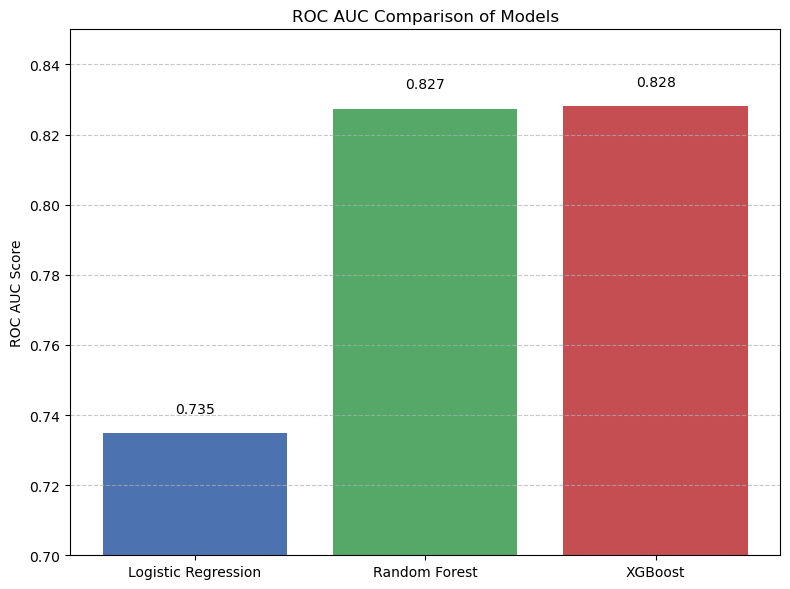

In [33]:
import matplotlib.pyplot as plt

# Updated ROC AUC scores (example values)
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
roc_auc_scores = [0.7348, 0.8274, 0.8280]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, roc_auc_scores, color=['#4c72b0', '#55a868', '#c44e52'])

# Annotate with exact values
for bar, score in zip(bars, roc_auc_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
             f"{score:.3f}", ha='center', va='bottom', fontsize=10)

# Adjust the y-axis to zoom in
plt.ylim(0.7, 0.85)

plt.title("ROC AUC Comparison of Models")
plt.ylabel("ROC AUC Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
